In [1]:
import pandas as pd
import numpy as np
import pdpipe as pdp
from matplotlib import pyplot as plt
%matplotlib inline
import sys
sys.path.append("..")

# Figure S1, 研究区

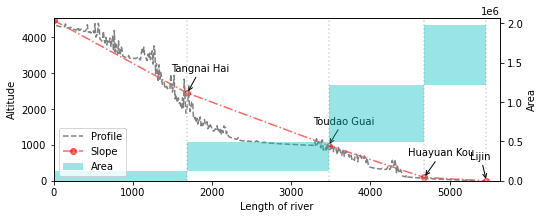

In [2]:
# 处理控制站点数据（来源于黄河流域综合规划）
features = pd.read_csv("../data/hydrology/river_features.csv")
features.columns = [k.strip() for k in features.columns]
length = features['length'].cumsum().values.tolist()
length.insert(0, 0)
fall = features['fall'].sort_index(ascending=False).cumsum().sort_index(ascending=True).values.tolist()
fall.insert(4, 0)

# 处理高程数据 （来源于Arcgis DEM数据）
from tools.processing import dbf_data_list, pd_read_dbf
altitude = pd_read_dbf('../data/hydrology/altitude_points_along_yr/altitude_points.dbf', usecols=['Shape_Leng', 'RASTERVALU'])
altitude['Shape_Leng'] /= 1000  # 单位将 米 转化为 千米
# altitude['RASTERVALU'] /= 1000  # 高程单位转化为千米
# 485号点开始，有几个数据是错误的位置，给他们标好顺序
reindex = list(np.arange(len(altitude) - 485, len(altitude))) + list(np.arange(len(altitude) - 485))
altitude.index = reindex 
altitude.sort_index(inplace=True)
# 将河流全长，按照点的数量进行划分
altitude['Shape_Leng'] = np.linspace(0, altitude['Shape_Leng'].iloc[0], len(altitude))

# 处理流域集水面积数据
stations = pd.read_csv('../data/hydrology/hydro_stations.csv')

# 作图
fig, ax = plt.subplots(figsize=(8, 3))

slope = ax.plot(length, fall, "-.o", color='red', alpha=0.6, label='Slope')
profile = ax.plot(altitude['Shape_Leng'], altitude['RASTERVALU'], '--', color='gray', label='Profile')
for i, x in enumerate(length):
    ax.axvline(x, ls=":", color='lightgray')

# 绘制图 2 每个站点的流域控制面积
ax2 = ax.twinx()
bottom = 0
for i in range(4):
    height = stations['catchment area'][i]
    width = length[i+1]-length[i]
    center = length[i] + width/2
    area = ax2.bar(x=length[i], align='edge', width=width, bottom=bottom, height=height, color='c', alpha=.4, label='Area')
    bottom += height
    ax.annotate(stations['station'][i],
            xy=(length[i+1], fall[i+1]), xycoords='data',
            xytext=(length[i+1]-200, fall[i+1]+600), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle='arc3'))

ax.set_xlim(altitude['Shape_Leng'].min(), altitude['Shape_Leng'].max()*1.06)
ax.set_ylim(altitude['RASTERVALU'].min(), altitude['RASTERVALU'].max())
ax.set_xlabel("Length of river")
ax.set_ylabel("Altitude")
ax2.set_ylabel("Area")
plt.legend(handles=profile + slope + [area], loc='lower left')
# 添加指示线，控制站名称

plt.savefig('../figures/sup/slope.jpg', dpi=300)
plt.show();

# Figure S2, 子区域的对比

## 区域差异合并作图

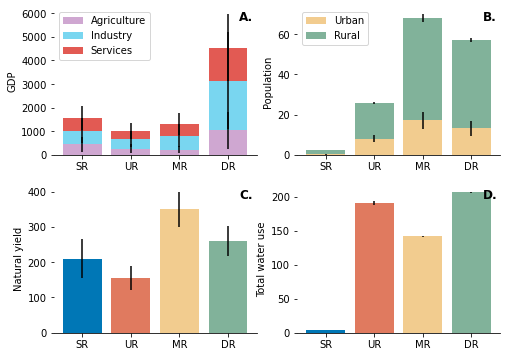

In [3]:
from script.region_differences import plot_gdp, plot_pop, plot_water, plot_wu
from tools.values import index_colors, region_colors

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

start_yr, end_yr = 1980, 2000
plot_gdp(ax1, index_colors, start_yr, end_yr)
plot_pop(ax2, region_colors[-2:], start_yr, end_yr)
plot_water(ax3, start_yr, end_yr, region_colors)
plot_wu(ax4, region_colors, start_yr, end_yr)

# 修饰图片
from tools.processing import get_position_by_ratio

labels = ["A.", "B.", "C.", "D."]
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    x, y =get_position_by_ratio(ax, 0.95, 0.93)
    ax.text(x, y, labels[i], ha='center', va='center', weight='bold', size='large')

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    ax.set_xlabel("")

plt.savefig("../figures/sup/region_differences.jpg", dpi=300)
plt.savefig("../figures/sup/region_differences.pdf", dpi=300)
plt.show();

In [4]:
from script.region_differences import get_consumptions_ratio
get_consumptions_ratio(1972)

0.7765110845359886

# Fig. SX 不同时期 GDP 贡献百分比

In [5]:
from tools.values import INDUSTRIES, INDUSTRIES_eng
from script.region_differences import extract_gdp_by_industry, get_yr_gdp_data

gdp = get_yr_gdp_data()
gdp_yr = pd.DataFrame()
for i, industry in enumerate(INDUSTRIES):
    gdp_yr[INDUSTRIES_eng[i]] = extract_gdp_by_industry(gdp, industry)

gdp_yr.head()

,Agriculture,Industry,Services
Year,,,
1965,170.65,124.34,73.41
1966,183.56,151.27,77.68
1967,189.50,136.87,77.31
1968,181.57,123.24,74.36
1969,194.46,155.47,80.74


(0.46321932681867534, 0.3375135722041259, 0.19926710097719874)


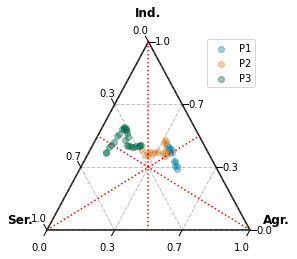

In [6]:
# 制作三元图
from tools.values import period_colors
points = []
points_1, points_2, points_3 = [], [], []
size_1, size_2, size_3 = [], [], []
scale = 100

z_ipwu, z_wdi, z_sfv = [gdp_yr[col] for col in gdp_yr]
for yr in gdp_yr.index:
    sumed = z_ipwu[yr] + z_wdi[yr] + z_sfv[yr]  # 这里点的大小是三者 z_score 相加
    point = (z_ipwu[yr]/sumed, z_wdi[yr]/sumed, z_sfv[yr]/sumed)
    points.append(point)
    if yr == 1965:
        print(point)
    if yr < 1978:
        points_1.append(point)
        size_1.append(sumed * scale)
    elif yr < 1993:
        points_2.append(point)
        size_2.append(sumed * scale)
    else:
        points_3.append(point)
        size_3.append(sumed * scale)

import ternary
fig, ax = plt.subplots(figsize=(4, 4))
figure, tax = ternary.figure(ax=ax, scale=1)
tax.boundary()
tax.gridlines(ls="-.", multiple=1./3, color="gray")
# Plot a few different styles with a legend
tax.scatter(points_1, marker='o', color=period_colors[0], label="P1", alpha=.4)
tax.scatter(points_2, marker='o', color=period_colors[1], label="P2", alpha=.4)
tax.scatter(points_3, marker='o', color=period_colors[2], label="P3", alpha=.4)
tax.plot(points, ls=':', lw='0.7')
fontsize = 12
offset = 0.15

tax.ticks(axis='brl', multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
# tax.ticks(axis='l', clockwise=True, multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

def get_point(yr):
    a = z_ipwu[yr] + z_wdi[yr] - z_sfv[yr]
    return (z_ipwu[yr]/a, z_wdi[yr]/a, z_sfv[yr]/a)

tax.set_axis_limits((0,1))
tax.line((0,0,1),(.5,.5,0), ls=":", color='red')
tax.line((0,1,0),(.5,0,.5), ls=":", color='red')
tax.line((1,0,0),(0,.5,.5), ls=":", color='red')
tax.right_corner_label("Agr.", fontsize=fontsize, offset=0.3, weight='bold')
tax.top_corner_label("Ind.", fontsize=fontsize, offset=0.25, weight='bold')
tax.left_corner_label("Ser.", fontsize=fontsize, offset=0.3, weight='bold')

tax.legend()
tax.show()
tax.savefig("../figures/sup/ternary.jpg", dpi=300)
tax.savefig("../figures/sup/ternary.pdf", dpi=300);

# Figure SX 节水措施

In [7]:
from tools.processing import get_region_by_province_name

saving_water = pd.read_excel("../data/saving_water.xlsx")
saving_water['Region'] = saving_water['Province'].apply(get_region_by_province_name)
saving_water.head()

,Province,Irrigated area,Channel lining,Pipeline water,Sprinkler irrigation,Drip irrigation,Region
0,Qinghai,273.39,74.31,0.00,2.00,0.00,SR
1,Sichuan,0.55,0.00,0.41,0.00,0.00,SR
2,Gansu,763.26,375.80,32.36,34.98,10.86,UR
3,Ningxia,668.88,169.10,19.70,11.63,6.70,UR
4,Neimeng,1558.77,427.28,212.03,25.96,2.45,UR


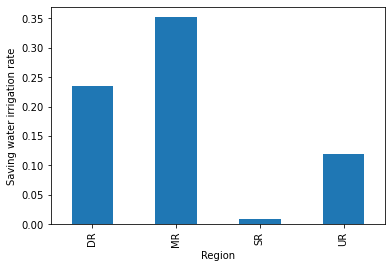

In [8]:
# 按区域进行加和
sw_region = saving_water.groupby("Region").sum()

# 计算每个区域的节水率
sw_region['Rate'] = sw_region.iloc[:, 2:].sum(axis=1) / sw_region['Irrigated area']

fig, ax = plt.subplots()
sw_region['Rate'].plot.bar(ax=ax)
ax.set_xlabel("Region")
ax.set_ylabel("Saving water irrigation rate")

plt.savefig('../figures/sup/saving_water.jpg', dpi=300)
plt.savefig('../figures/sup/saving_water.pdf', dpi=300)
plt.show();

# Fig SX. 法律政策

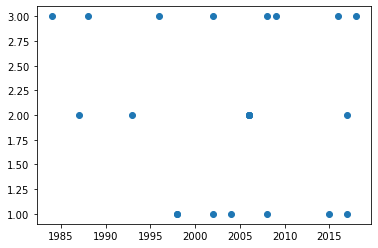

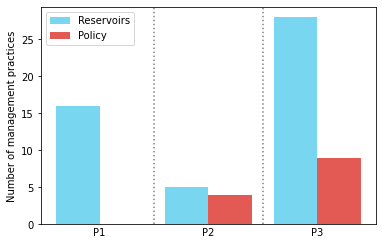

In [9]:
policy = pd.read_excel("..\data\policy.xlsx")
def div_levels(x):
    if x == "National People's Congress of the PRC":
        return 3
    elif x == "State Council of the PRC":
        return 2
    elif x == "Ministry of Water Resources of the PRC":
        return 1

policy['level'] = policy['agency'].apply(div_levels)
plt.scatter(policy['施行or修订时间'], policy['level'])

# 图3： =================== 管理措施 =====================
# management.plot.bar(color=['#79D6F0', '#E25A53'], ax=ax3)

fig, ax3 = plt.subplots()
ax3.bar(
    x=[-0.2, 0.8, 1.8],
    height=[16, 5, 28],
    width=0.4,
    label='Reservoirs',
    color='#79D6F0'
)
ax3.bar(
    x=[0.2, 1.2, 2.2],
    height=[0, 4, 9],
    width=0.4,
    label='Policy',
    color='#E25A53'
)
ax3.set_ylabel('Number of management practices')
for tick in ax3.get_xticklabels():  # 旋转角度
    tick.set_rotation(0)  # 轴标签旋转
# ax3.set_yticks(np.arange(-0.01, 0.021, 0.01))
ax3.set_xticks(np.arange(3))
ax3.set_xticklabels(["P1", "P2", "P3"])
ax3.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
ax3.axvline(1.5, ls=':', color='gray')
ax3.axvline(0.5, ls=':', color='gray')
ax3.legend()
plt.savefig(r'../figures/sup/managements.jpg', dpi=300)
plt.savefig(r'../figures/sup/managements.pdf', dpi=300)
plt.show();

# Fig SX 天然径流量变化

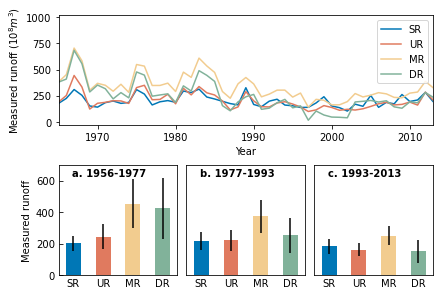

In [10]:
from matplotlib.gridspec import GridSpec
from tools.values import region_colors

# 加载径流和水库数据
use_cols = {
    '唐乃亥': 'SR',  # 唐乃亥控制源区
    '头道拐': 'UR',  # 头道拐控制上游
    '花园口': 'MR',  # 花园口控制中游
    '利津': 'DR'     # 利津控制下游
}
measured_runoff = pd.read_csv(r'../data/hydrology/1956-2016_runoff.csv', index_col='年份')
measured_runoff = measured_runoff.loc[:, use_cols.keys()]
measured_runoff.rename(use_cols, axis=1, inplace=True)

fig = plt.figure(figsize=(6, 4), constrained_layout=True)
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[0, :])
axs = [ax1, ax2, ax3]

endpoints = [1977, 1993, 2013]
markers = ["a.", "b.", "c."]
startpoint = measured_runoff.index.min()
for i, endpoint in enumerate(endpoints):
    ax = axs[i]
    use_data = measured_runoff.loc[startpoint: endpoint, :]
    use_data.mean().plot.bar(yerr=use_data.std(), ax=ax, color=region_colors)
    
    ax.set_ylim(0, 700)
    ax.text(1.2, 650, "{} {}-{}".format(markers[i], startpoint, endpoint), ha='center', va='center', weight='bold')
    startpoint = endpoint
    ax.axes.get_yaxis().set_visible(False)
    ax.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
    ax.tick_params(axis='y', tickdir='in', bottom=False, labelrotation=0)

axs[0].set_ylabel("Measured runoff")
axs[0].axes.get_yaxis().set_visible(True)

measured_runoff.plot(ax=ax4, color=region_colors)
ax4.set_xlabel("Year")
ax4.set_ylabel("Measured runoff ($10^8m^3$)")
ax4.set_xlim(1965, 2013)

plt.savefig("../figures/sup/sf_measured_runoff.pdf", dpi=300)
plt.savefig("../figures/sup/sf_measured_runoff.jpg", dpi=300)
plt.show();